In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

print("Setup complete")

Setup complete


## 1. Load Data

In [26]:
# Load the combined sequences
X = np.load('combined_X_sequences.npy')
y = np.load('combined_y_labels.npy')

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y)*100:.1f}%)")

X shape: (23705, 60, 86)
y shape: (23705,)

Class distribution:
  Class 0: 8408 (35.5%)
  Class 1: 7796 (32.9%)
  Class 2: 7501 (31.6%)


## 2. Feature Statistics

Analyze the distribution of each feature across all timesteps.

In [27]:
# Reshape to analyze all features: (samples * timesteps, features)
n_samples, n_timesteps, n_features = X.shape
X_flat = X.reshape(-1, n_features)

print(f"Analyzing {n_features} features across {n_samples * n_timesteps} total timesteps")

# Calculate statistics for each feature
feature_stats = pd.DataFrame({
    'feature_idx': range(n_features),
    'mean': X_flat.mean(axis=0),
    'std': X_flat.std(axis=0),
    'min': X_flat.min(axis=0),
    'max': X_flat.max(axis=0),
    'median': np.median(X_flat, axis=0),
    'q25': np.percentile(X_flat, 25, axis=0),
    'q75': np.percentile(X_flat, 75, axis=0),
})

feature_stats['range'] = feature_stats['max'] - feature_stats['min']
feature_stats['iqr'] = feature_stats['q75'] - feature_stats['q25']

print("\nFeature Statistics Summary:")
print(feature_stats.describe())

Analyzing 86 features across 1422300 total timesteps

Feature Statistics Summary:
       feature_idx       mean        std        min        max        median  \
count    86.000000  86.000000  86.000000  86.000000  86.000000  8.600000e+01   
mean     42.500000   0.022596   0.862058 -17.401042  27.602631 -1.751013e-03   
std      24.969982   0.039828   0.017211  15.444558  14.343599  2.126830e-02   
min       0.000000  -0.002256   0.841562 -54.146820   0.582363 -1.458681e-01   
25%      21.250000  -0.000020   0.845623 -29.568106  19.837296 -2.158564e-09   
50%      42.500000   0.000027   0.861204 -19.897212  27.937088  8.608349e-07   
75%      63.750000   0.048630   0.878085  -0.737449  37.200087  1.710050e-04   
max      85.000000   0.153069   0.894528  -0.490875  56.031393  9.347163e-02   

             q25        q75      range        iqr  
count  86.000000  86.000000  86.000000  86.000000  
mean   -0.317404   0.273668  45.003672   0.591072  
std     0.142143   0.116269  15.516365   

## 3. Identify Problematic Features

In [28]:
# Check for features with unusual characteristics
print("=" * 80)
print("POTENTIAL ISSUES:")
print("=" * 80)

# 1. Near-zero variance features (not useful for learning)
low_var_threshold = 0.01
low_var_features = feature_stats[feature_stats['std'] < low_var_threshold]
if len(low_var_features) > 0:
    print(f"\n⚠️  Features with very low variance (std < {low_var_threshold}):")
    print(low_var_features[['feature_idx', 'mean', 'std', 'min', 'max']])
else:
    print(f"\n✓ No features with extremely low variance")

# 2. Features with extreme values
high_range_features = feature_stats[feature_stats['range'] > 100]
if len(high_range_features) > 0:
    print(f"\n⚠️  Features with large range (> 100):")
    print(high_range_features[['feature_idx', 'mean', 'std', 'min', 'max', 'range']])
else:
    print(f"\n✓ No features with extreme ranges")

# 3. Features with unusual scale
mean_std = feature_stats['std'].mean()
std_std = feature_stats['std'].std()
outlier_std_features = feature_stats[
    (feature_stats['std'] > mean_std + 2*std_std) | 
    (feature_stats['std'] < mean_std - 2*std_std)
]
if len(outlier_std_features) > 0:
    print(f"\n⚠️  Features with unusual std (>2 sigma from mean std={mean_std:.3f}):")
    print(outlier_std_features[['feature_idx', 'mean', 'std']])
else:
    print(f"\n✓ All features have similar scale")

# 4. Check for constant features
constant_features = feature_stats[feature_stats['std'] == 0]
if len(constant_features) > 0:
    print(f"\n⚠️  Constant features (no variation):")
    print(constant_features[['feature_idx', 'mean', 'std']])
else:
    print(f"\n✓ No constant features")

POTENTIAL ISSUES:

✓ No features with extremely low variance

✓ No features with extreme ranges

✓ All features have similar scale

✓ No constant features


## 4. Visualize Feature Distributions

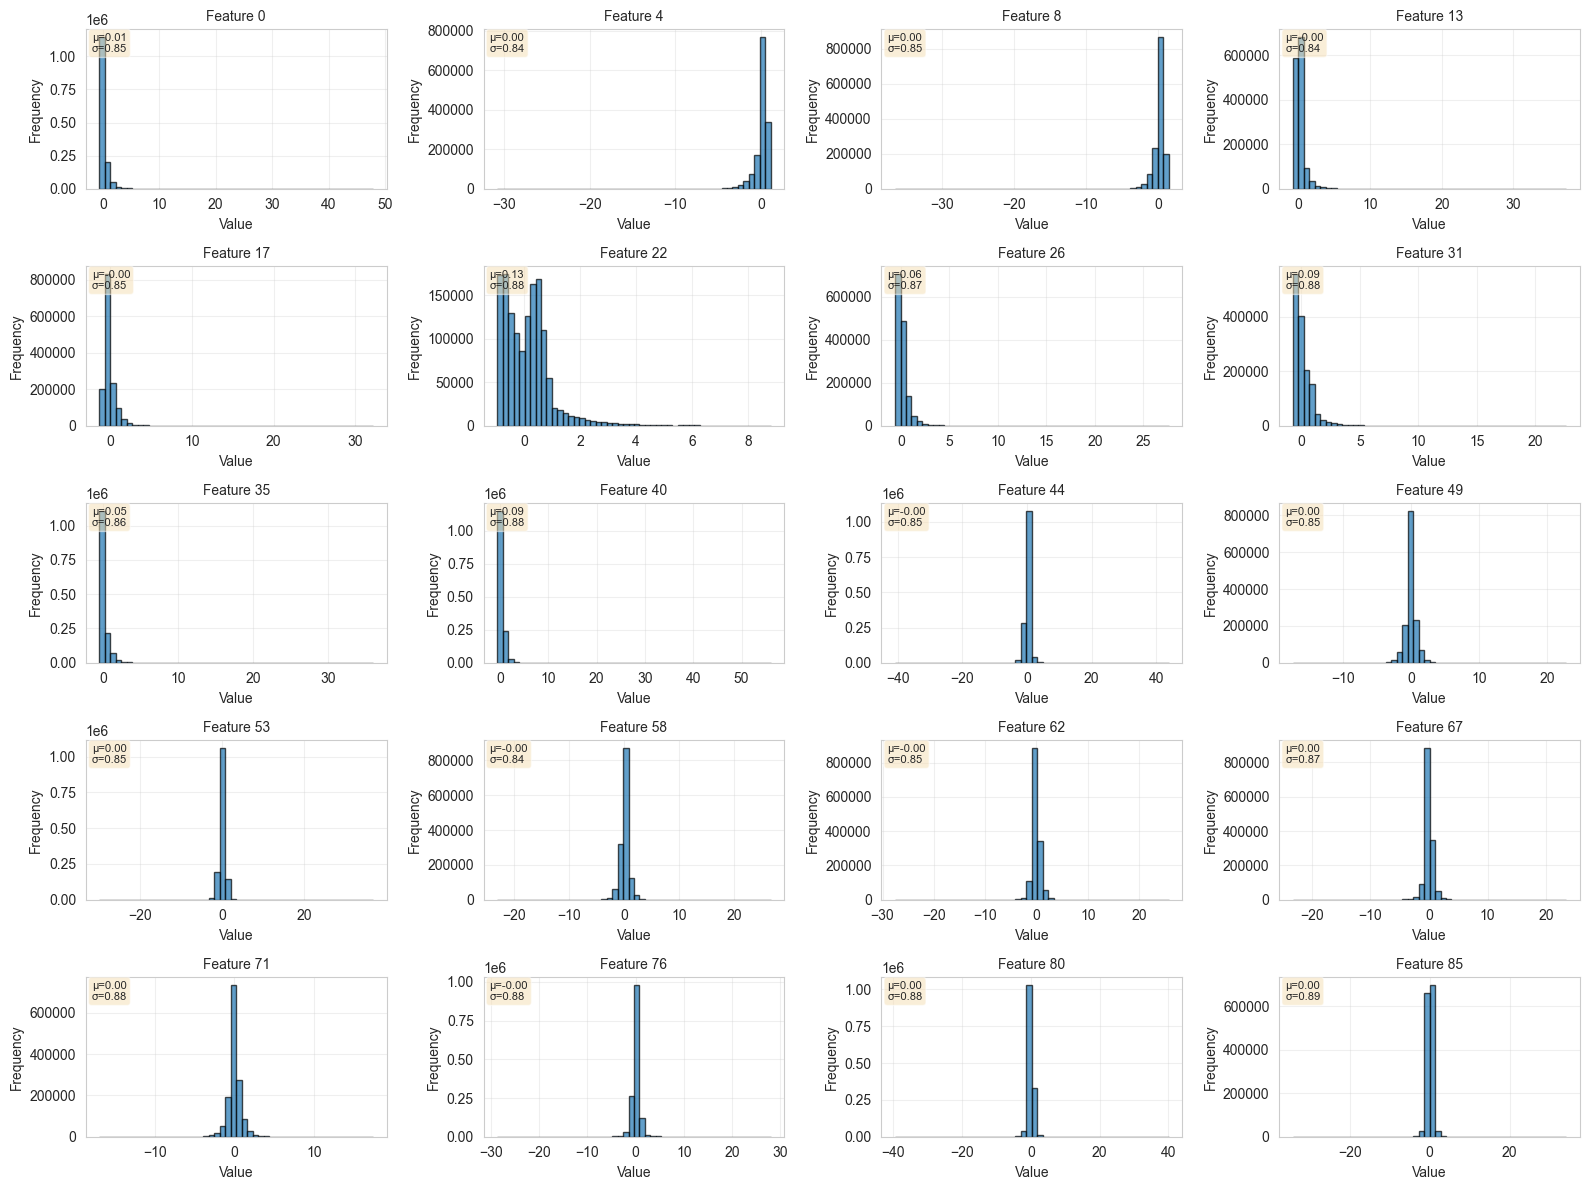

Saved feature distributions to feature_distributions.png


In [29]:
# Plot histograms for a sample of features
fig, axes = plt.subplots(5, 4, figsize=(16, 12))
axes = axes.flatten()

# Sample 20 features evenly across the feature space
feature_indices = np.linspace(0, n_features-1, min(20, n_features), dtype=int)

for i, feature_idx in enumerate(feature_indices):
    ax = axes[i]
    feature_data = X_flat[:, feature_idx]
    
    ax.hist(feature_data, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'Feature {feature_idx}', fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add stats text
    stats_text = f'μ={feature_data.mean():.2f}\nσ={feature_data.std():.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=8, bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved feature distributions to feature_distributions.png")

## 5. Feature Correlation Analysis

Computing correlation matrix on 10000 samples...


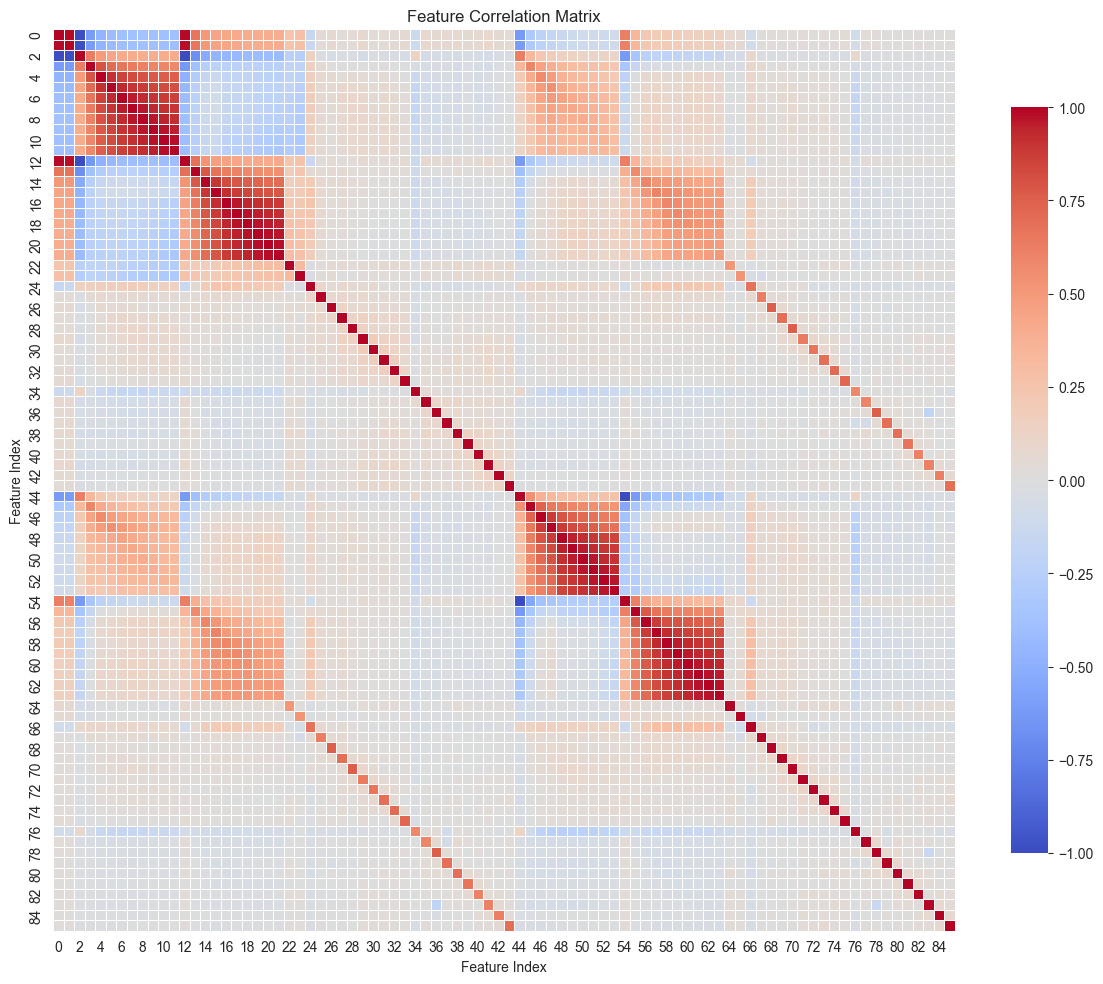

Saved correlation matrix to feature_correlation_matrix.png


In [30]:
# Calculate correlation matrix (sample to avoid memory issues)
sample_size = min(10000, len(X_flat))
sample_indices = np.random.choice(len(X_flat), sample_size, replace=False)
X_sample = X_flat[sample_indices]

print(f"Computing correlation matrix on {sample_size} samples...")
corr_matrix = np.corrcoef(X_sample.T)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.tight_layout()
plt.savefig('feature_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved correlation matrix to feature_correlation_matrix.png")

## 6. Highly Correlated Features

In [31]:
# Find highly correlated feature pairs
high_corr_threshold = 0.95
high_corr_pairs = []

for i in range(n_features):
    for j in range(i+1, n_features):
        corr_val = corr_matrix[i, j]
        if abs(corr_val) > high_corr_threshold:
            high_corr_pairs.append((i, j, corr_val))

if high_corr_pairs:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > {high_corr_threshold}):")
    print("\nFeature1 | Feature2 | Correlation")
    print("-" * 40)
    for i, j, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:20]:
        print(f"{i:8d} | {j:8d} | {corr:11.4f}")
    
    if len(high_corr_pairs) > 20:
        print(f"... and {len(high_corr_pairs) - 20} more pairs")
else:
    print(f"\n✓ No highly correlated feature pairs (threshold: {high_corr_threshold})")


⚠️  Found 31 highly correlated feature pairs (|r| > 0.95):

Feature1 | Feature2 | Correlation
----------------------------------------
       2 |       12 |     -1.0000
      44 |       54 |     -1.0000
       0 |        1 |      0.9903
       0 |       12 |      0.9874
       0 |        2 |     -0.9874
       1 |       12 |      0.9829
       1 |        2 |     -0.9829
      20 |       21 |      0.9827
      19 |       20 |      0.9803
      10 |       11 |      0.9796
      62 |       63 |      0.9756
      18 |       19 |      0.9747
      61 |       62 |      0.9737
       9 |       10 |      0.9720
      17 |       18 |      0.9702
      52 |       53 |      0.9687
      60 |       61 |      0.9682
      51 |       52 |      0.9659
       8 |        9 |      0.9651
       7 |        8 |      0.9643
... and 11 more pairs


## 7. Class Separability Analysis

Check if features show different distributions across classes.

In [32]:
# For each feature, compute mean value per class
# Use the last timestep of each sequence as representative
X_last_timestep = X[:, -1, :]  # (n_samples, n_features)

class_means = {}
for cls in np.unique(y):
    class_mask = y == cls
    class_means[cls] = X_last_timestep[class_mask].mean(axis=0)

# Compute feature importance based on class separation
feature_separability = pd.DataFrame({
    'feature_idx': range(n_features),
    'class_0_mean': class_means[0],
    'class_1_mean': class_means[1],
    'class_2_mean': class_means[2],
})

feature_separability['diff_0_1'] = abs(feature_separability['class_0_mean'] - feature_separability['class_1_mean'])
feature_separability['diff_0_2'] = abs(feature_separability['class_0_mean'] - feature_separability['class_2_mean'])
feature_separability['diff_1_2'] = abs(feature_separability['class_1_mean'] - feature_separability['class_2_mean'])
feature_separability['max_diff'] = feature_separability[['diff_0_1', 'diff_0_2', 'diff_1_2']].max(axis=1)

# Sort by max difference
feature_separability = feature_separability.sort_values('max_diff', ascending=False)

print("\nTop 20 features with best class separation:")
print(feature_separability.head(20)[['feature_idx', 'class_0_mean', 'class_1_mean', 'class_2_mean', 'max_diff']])

print("\nBottom 20 features with worst class separation:")
print(feature_separability.tail(20)[['feature_idx', 'class_0_mean', 'class_1_mean', 'class_2_mean', 'max_diff']])


Top 20 features with best class separation:
    feature_idx  class_0_mean  class_1_mean  class_2_mean  max_diff
22           22      0.229476      0.220679     -0.080582  0.310058
23           23      0.258710      0.219448     -0.038614  0.297324
10           10     -0.037303     -0.065571      0.116660  0.182231
1             1      0.091955      0.095399     -0.086689  0.182088
19           19      0.037418      0.064121     -0.117536  0.181657
9             9     -0.036924     -0.064130      0.114847  0.178977
18           18      0.035021      0.064265     -0.114433  0.178698
21           21      0.042884      0.059039     -0.118919  0.177957
11           11     -0.037452     -0.063511      0.114365  0.177876
0             0      0.065701      0.066812     -0.108816  0.175628
8             8     -0.031909     -0.064954      0.109997  0.174951
20           20      0.040126      0.059025     -0.115507  0.174532
17           17      0.036022      0.061808     -0.111880  0.173688
7  

## 8. Temporal Dynamics

Analyze how features change over the sequence length.

In [33]:
# For each feature, compute mean across timesteps
feature_temporal_std = np.std(X.mean(axis=0), axis=0)  # std across timesteps

temporal_df = pd.DataFrame({
    'feature_idx': range(n_features),
    'temporal_variability': feature_temporal_std
})
temporal_df = temporal_df.sort_values('temporal_variability', ascending=False)

print("Features with highest temporal variability (change over time):")
print(temporal_df.head(20))

print("\nFeatures with lowest temporal variability (static):")
print(temporal_df.tail(20))

Features with highest temporal variability (change over time):
    feature_idx  temporal_variability
22           22              0.001593
23           23              0.001096
13           13              0.000943
7             7              0.000905
8             8              0.000905
6             6              0.000901
9             9              0.000893
4             4              0.000886
19           19              0.000872
10           10              0.000854
21           21              0.000844
5             5              0.000843
11           11              0.000836
18           18              0.000836
20           20              0.000827
14           14              0.000816
17           17              0.000796
16           16              0.000774
15           15              0.000758
3             3              0.000707

Features with lowest temporal variability (static):
    feature_idx  temporal_variability
81           81              0.000047
49        

## 9. Check for NaN/Inf Values

In [34]:
# Check for problematic values
nan_count = np.isnan(X_flat).sum()
inf_count = np.isinf(X_flat).sum()

print(f"NaN values: {nan_count}")
print(f"Inf values: {inf_count}")

if nan_count > 0:
    nan_features = np.where(np.isnan(X_flat).sum(axis=0) > 0)[0]
    print(f"\n⚠️  Features with NaN values: {nan_features}")

if inf_count > 0:
    inf_features = np.where(np.isinf(X_flat).sum(axis=0) > 0)[0]
    print(f"\n⚠️  Features with Inf values: {inf_features}")

if nan_count == 0 and inf_count == 0:
    print("\n✓ No NaN or Inf values detected")

NaN values: 0
Inf values: 0

✓ No NaN or Inf values detected


## 10. Summary and Recommendations

In [35]:
print("=" * 80)
print("FEATURE ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nTotal features: {n_features}")
print(f"Total samples: {n_samples}")
print(f"Sequence length: {n_timesteps}")

print(f"\nFeature scale statistics:")
print(f"  Mean std: {feature_stats['std'].mean():.4f}")
print(f"  Min std: {feature_stats['std'].min():.4f}")
print(f"  Max std: {feature_stats['std'].max():.4f}")
print(f"  Std of std: {feature_stats['std'].std():.4f}")

print(f"\nData quality:")
print(f"  NaN values: {nan_count}")
print(f"  Inf values: {inf_count}")
print(f"  Low variance features: {len(low_var_features)}")
print(f"  High correlation pairs: {len(high_corr_pairs)}")

print("\n" + "=" * 80)
print("RECOMMENDATIONS:")
print("=" * 80)

if len(low_var_features) > 0:
    print(f"\n1. Consider removing {len(low_var_features)} low-variance features")
    
if len(high_corr_pairs) > 10:
    print(f"\n2. Consider removing redundant features ({len(high_corr_pairs)} highly correlated pairs)")

if feature_stats['std'].std() > feature_stats['std'].mean() * 0.5:
    print(f"\n3. Feature scales vary significantly - standardization recommended")
else:
    print(f"\n3. ✓ Feature scales are relatively consistent")

print(f"\n4. Top features for class separation (check feature_separability DataFrame)")
print(f"5. Review feature distribution plots to identify skewed or outlier features")

FEATURE ANALYSIS SUMMARY

Total features: 86
Total samples: 23705
Sequence length: 60

Feature scale statistics:
  Mean std: 0.8621
  Min std: 0.8416
  Max std: 0.8945
  Std of std: 0.0172

Data quality:
  NaN values: 0
  Inf values: 0
  Low variance features: 0
  High correlation pairs: 31

RECOMMENDATIONS:

2. Consider removing redundant features (31 highly correlated pairs)

3. ✓ Feature scales are relatively consistent

4. Top features for class separation (check feature_separability DataFrame)
5. Review feature distribution plots to identify skewed or outlier features


## 11. Feature Selection

Select the most informative features based on multiple criteria.


In [36]:
# Step 1: Remove highly correlated features
# Keep only one from each correlated pair (prefer norm over delta)

selected_features = set(range(n_features))

# Process high correlation pairs - remove the second feature in each pair
for i, j, corr in high_corr_pairs:
    if i in selected_features and j in selected_features:
        # Remove the one with higher index (arbitrary but consistent)
        selected_features.remove(j)

print(f"After removing highly correlated features: {len(selected_features)} features remaining")

# Step 2: Remove low variance features
for feat_idx in low_var_features['feature_idx'].values:
    if feat_idx in selected_features:
        selected_features.remove(feat_idx)

print(f"After removing low variance features: {len(selected_features)} features remaining")

# Step 3: Keep only features with good class separability
# Use features with max_diff above median
median_separability = feature_separability['max_diff'].median()
good_separability_features = set(
    feature_separability[feature_separability['max_diff'] > median_separability]['feature_idx'].values
)

selected_features = selected_features.intersection(good_separability_features)
print(f"After filtering by class separability: {len(selected_features)} features remaining")

# Step 4: Keep features with temporal variability
# Use features with temporal_variability above median
median_temporal = temporal_df['temporal_variability'].median()
good_temporal_features = set(
    temporal_df[temporal_df['temporal_variability'] > median_temporal]['feature_idx'].values
)

selected_features = selected_features.intersection(good_temporal_features)
print(f"After filtering by temporal variability: {len(selected_features)} features remaining")

# Convert to sorted list
selected_features_list = sorted(list(selected_features))

print(f"\n{'='*80}")
print(f"FINAL SELECTED FEATURES: {len(selected_features_list)}")
print(f"{'='*80}")
print(f"\nSelected feature indices: {selected_features_list}")

After removing highly correlated features: 70 features remaining
After removing low variance features: 70 features remaining
After filtering by class separability: 34 features remaining
After filtering by temporal variability: 33 features remaining

FINAL SELECTED FEATURES: 33

Selected feature indices: [0, 3, 4, 5, 6, 8, 10, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43]


## 12. Save Filtered Dataset

In [37]:
# Extract only the selected features
X_filtered = X[:, :, selected_features_list]

print(f"Original shape: {X.shape}")
print(f"Filtered shape: {X_filtered.shape}")

# Save the filtered dataset
np.save('combined_X_sequences_filtered.npy', X_filtered)
np.save('combined_y_labels_filtered.npy', y)  # Labels stay the same

# Save feature selection metadata
import json

metadata = {
    'original_n_features': int(n_features),
    'filtered_n_features': len(selected_features_list),
    'selected_feature_indices': [int(x) for x in selected_features_list],  # Convert numpy int64 to Python int
    'selection_criteria': {
        'removed_high_correlation': len(high_corr_pairs),
        'removed_low_variance': int(len(low_var_features)),
        'separability_threshold': float(median_separability),
        'temporal_threshold': float(median_temporal)
    }
}

with open('filtered_features_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nSaved filtered dataset:")
print("  - combined_X_sequences_filtered.npy")
print("  - combined_y_labels_filtered.npy")
print("  - filtered_features_metadata.json")

Original shape: (23705, 60, 86)
Filtered shape: (23705, 60, 33)

Saved filtered dataset:
  - combined_X_sequences_filtered.npy
  - combined_y_labels_filtered.npy
  - filtered_features_metadata.json

Saved filtered dataset:
  - combined_X_sequences_filtered.npy
  - combined_y_labels_filtered.npy
  - filtered_features_metadata.json


## 13. Visualize Selected Features

Statistics for selected features:

Scale consistency:
  Mean std: 0.8637
  Min std: 0.8416
  Max std: 0.8898
  Std of std: 0.0164

Class separability:
  Mean max_diff: 0.0991
  Min max_diff: 0.0141
  Max max_diff: 0.3101


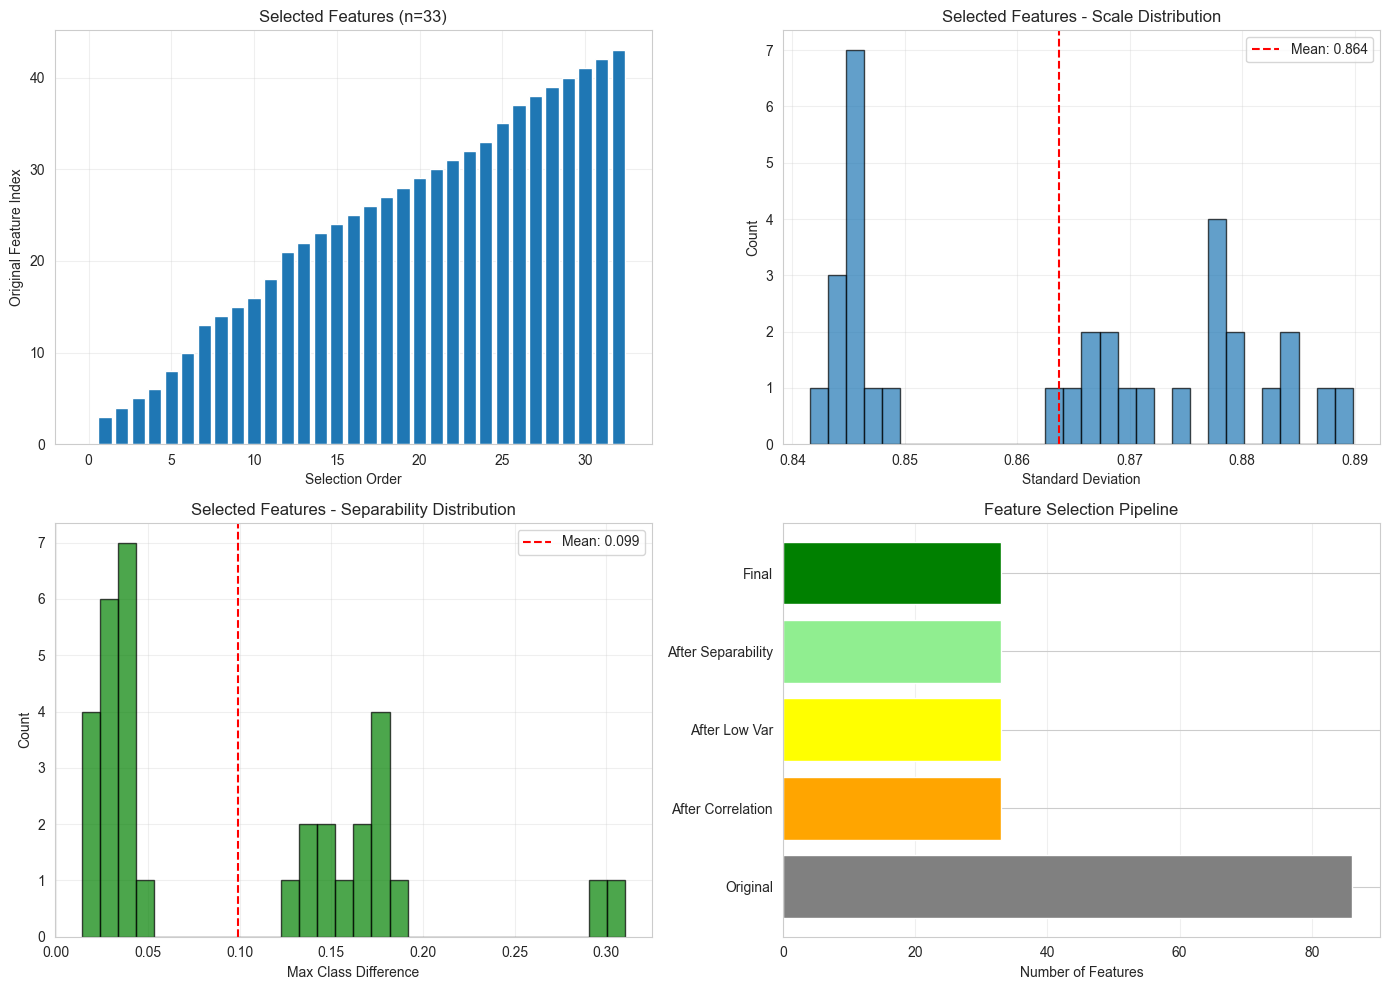


Saved visualization to feature_selection_summary.png


In [38]:
# Show statistics for selected features
selected_stats = feature_stats[feature_stats['feature_idx'].isin(selected_features_list)].copy()
selected_separability = feature_separability[feature_separability['feature_idx'].isin(selected_features_list)].copy()

print("Statistics for selected features:")
print("\nScale consistency:")
print(f"  Mean std: {selected_stats['std'].mean():.4f}")
print(f"  Min std: {selected_stats['std'].min():.4f}")
print(f"  Max std: {selected_stats['std'].max():.4f}")
print(f"  Std of std: {selected_stats['std'].std():.4f}")

print("\nClass separability:")
print(f"  Mean max_diff: {selected_separability['max_diff'].mean():.4f}")
print(f"  Min max_diff: {selected_separability['max_diff'].min():.4f}")
print(f"  Max max_diff: {selected_separability['max_diff'].max():.4f}")

# Plot selected features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Feature indices selected
ax = axes[0, 0]
ax.bar(range(len(selected_features_list)), selected_features_list)
ax.set_xlabel('Selection Order')
ax.set_ylabel('Original Feature Index')
ax.set_title(f'Selected Features (n={len(selected_features_list)})')
ax.grid(True, alpha=0.3)

# 2. Std distribution of selected features
ax = axes[0, 1]
ax.hist(selected_stats['std'], bins=30, alpha=0.7, edgecolor='black')
ax.axvline(selected_stats['std'].mean(), color='red', linestyle='--', label=f'Mean: {selected_stats["std"].mean():.3f}')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Count')
ax.set_title('Selected Features - Scale Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Class separability of selected features
ax = axes[1, 0]
ax.hist(selected_separability['max_diff'], bins=30, alpha=0.7, edgecolor='black', color='green')
ax.axvline(selected_separability['max_diff'].mean(), color='red', linestyle='--', label=f'Mean: {selected_separability["max_diff"].mean():.3f}')
ax.set_xlabel('Max Class Difference')
ax.set_ylabel('Count')
ax.set_title('Selected Features - Separability Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Comparison: before vs after
ax = axes[1, 1]
comparison_data = [
    ['Original', n_features],
    ['After Correlation', len(selected_features) + len(low_var_features)],
    ['After Low Var', len(selected_features)],
    ['After Separability', len(selected_features.intersection(good_separability_features))],
    ['Final', len(selected_features_list)]
]
labels = [x[0] for x in comparison_data]
values = [x[1] for x in comparison_data]
colors = ['gray', 'orange', 'yellow', 'lightgreen', 'green']
ax.barh(labels, values, color=colors)
ax.set_xlabel('Number of Features')
ax.set_title('Feature Selection Pipeline')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_selection_summary.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nSaved visualization to feature_selection_summary.png")